In [2]:
import sys
import os
from BreakageClassifier.code.crawl.crawl import Crawler
from dotenv import load_dotenv, find_dotenv
from pathlib import Path
from openwpm.command_sequence import CommandSequence
from openwpm.commands.browser_commands import GetCommand
from openwpm.config import BrowserParams, ManagerParams
from openwpm.storage.sql_provider import SQLiteStorageProvider
from openwpm.storage.leveldb import LevelDbProvider
from openwpm.task_manager import TaskManager
from pathlib import Path
import importlib
import pandas as pd
from BreakageClassifier.code.crawl.addon import (
    AddonSetupCommand,
    FilterListLoadCommand,
)
from BreakageClassifier.code.crawl.conf import UBLOCK_XPI_PATH
from BreakageClassifier.code.crawl.interact import (
    SelectorInteractCommand,
    create_interaction_table,
)
from BreakageClassifier.code.crawl.error import (
    AddErrorHandlerCommand,
    HarvestErrorsCommand,
    create_errors_table,
)

from BreakageClassifier.code.crawl.dom import create_dom_table
import BreakageClassifier.code.run as features
from BreakageClassifier.code.graph.database import Database


load_dotenv()
DOTENV_PATH = find_dotenv()
DIR = Path(DOTENV_PATH).parent
IN_PATH = Path("forums-out/ublock")
OUT_PATH = Path("crawl-out/ublock/")

SALIENCY_MODEL_PATH = DIR.joinpath("../WebModelGen/block_classifier/pretrained-models/model-0.joblib").resolve()

CRAWL_OUT_DIR_EASYLIST = DIR.joinpath("crawl-out/easylist/datadir-test-saliency/")

CRAWL_OUT_DIR_UBLOCK = DIR.joinpath("crawl-out/ublock/datadir-22-5-2023-with-console-error")

class EASYLIST:
    CRAWL_DIR = CRAWL_OUT_DIR_EASYLIST
    DB_PATH = CRAWL_OUT_DIR_EASYLIST.joinpath('crawl-data.sqlite')
    EXP_PATH = CRAWL_OUT_DIR_EASYLIST.joinpath('experiments.csv')
    FILTERLISTS_DIR = DIR.joinpath("forums-out/easylist/filterlists")
    OUTPUT_DIR = DIR.joinpath("error-handling-out/easylist/").joinpath(CRAWL_OUT_DIR_EASYLIST.name)
    
class UBLOCK:
    CRAWL_DIR = CRAWL_OUT_DIR_UBLOCK
    DB_PATH = CRAWL_OUT_DIR_UBLOCK.joinpath('crawl-data.sqlite')
    EXP_PATH = CRAWL_OUT_DIR_UBLOCK.joinpath('experiments.csv')
    FILTERLISTS_DIR = DIR.joinpath("forums-out/ublock/filterlists")
    OUTPUT_DIR = DIR.joinpath("error-handling-out/ublock/").joinpath(CRAWL_OUT_DIR_UBLOCK.name)


In [ ]:
# reloading libraries that change
# importlib.reload(features.dl)

In [3]:
# get a site with dynamic error
df = pd.read_csv(IN_PATH.joinpath("ublock-data.csv"))
dynamic_df = df[(df['label'] == 'D') & (df['should_include'] == True)]

for _, row in dynamic_df[['test_url', 'id', 'category']].iterrows():
    print(f"{row.id},https://github.com/uBlockOrigin/uAssets/issues/{row.id},{row.test_url}" )

13537,https://github.com/uBlockOrigin/uAssets/issues/13537,https://atomohd.org/descargar/torrent/serie/the-boys/temporada-3/capitulo-01/
13493,https://github.com/uBlockOrigin/uAssets/issues/13493,https://jobs.weser-kurier.de/OfferDetail?cn=EtZZKCWAWlRhUctXGiaWcFN0DGN65K4k633mGc80PzpXrxGTJFvtezwpkTAaAgzSB2mqxaTwVLhE87Ge4Yj0GJtup1JLi-ppMqTs0_2Z-wwz-tBJJ88N50PE2jlFwbWLgLIA95Gtq61zln6L71dCM7WLU5qiDdc96YaWu4c9-vNnlTGUYgjoIYi-0cKnfGe0-gbEPpalz5HG2lV5mRGB8ZsPZmgODMJzxsIyP8Z0oDj4eGnKw2ABJ_5w7DLm3yH8i9r15GsucBNYTdofOEv-NSu0LTLBa6OoPECTrfJuPO_jvliM6liub-41nzzl3zWg-7FVcQYVX267qoduT5Y3uDK14_FHwA0YB1CuaUFnag4_EzKhv40lSl7DVpBrf3lbDyxdVF-mhrBMxeUzPvSRP1Uib2e03FLpePB63fMHNYFonTQF1H-0RrPaF_7IqK0bFZzw7TymcFHDYpJr06m_Dw3eg94N34wi1j-k0-aCRwTpPBaTEd-NQV8zs9-w244bhdmr79QcM1uCCwSuCh-o5KB5xAcYGmpAjT0qdks3rpgEAJh3csvyyDkpkmhaiTP56bBbGdJalRlHvh59ZTYu-ChLqU1GbUZBx2JZQWbECLwPvrNHW69vT5L7Faw2Nk6c-xPmwnlvOmadCv50alBjpB3p_42FOebbumWM5ha4mTL1HnrNXQZGxkgAC8HpyywNBPI5d0-Ng2WzWlxv2IuEj8N0XOyAVH7rdp7glKwDFI6WXnIuhrZddcU8

In [4]:
ISSUE_ID = 13489
issue = dynamic_df[dynamic_df['id'] == ISSUE_ID].iloc[0]

print(issue.issue_url)
print(issue)
ISSUE_INDEX = df.id.values.tolist().index(ISSUE_ID)
print("issue index", ISSUE_INDEX)

TEST_URL = issue.test_url

CLICKABLE_CSS_SELECTOR = ".jobOfferSubmitItem"

https://github.com/uBlockOrigin/uAssets/issues/13489
id                                                            13489
title                                           job.nw.de: breakage
created_at                                     2022-05-31T14:02:22Z
before_rule                                                    None
after_rule        \n! https://github.com/uBlockOrigin/uAssets/is...
repo                                           uBlockOrigin/uAssets
before_commit              52e1ebafd3a4012951972d46b8efeadff1a6d78a
after_commit               3fa45a526548f420868d6dff72514f9da10ae02d
directories       ["filters/annoyances.txt", "filters/lan-block....
category                                                     Button
label                                                             D
raw_post          the link "Anmelden" (Login), button "Job Alarm...
lang                                                             en
issue_url         https://github.com/uBlockOrigin/uAssets/issue

### Investigating error instrumentaiton

In [ ]:
browser_params = [BrowserParams(display_mode="headless")]
# browser_params = [BrowserParams()]

# Update browser configuration (use this for per-browser settings)
for browser_param in browser_params:
    # Record HTTP Requests and Responses
    browser_param.http_instrument = True
    # Record cookie changes
    browser_param.cookie_instrument = True
    # Record Navigations
    browser_param.navigation_instrument = True
    # Record JS Web API calls
    browser_param.js_instrument = True
    # Record the callstack of all WebRequests made
    browser_param.callstack_instrument = True
    # Record DNS resolution
    browser_param.dns_instrument = True
    # save the javascript files
    browser_param.save_content = "script"

    browser_param.js_instrument_settings = [
        "collection_fingerprinting",
        {
            "window": {
                "propertiesToInstrument": [
                    "name",
                    "localStorage",
                    "sessionStorage",
                    "onerror"
                ],
                "nonExistingPropertiesToInstrument": [
                    "last_log_event",
                ],
            }
        },
        { "window.console":{
            "logCallStack": True
        }}
    ]
    

manager_params = ManagerParams(
    num_browsers=1,
    data_directory=Path("./error-handling-out/datadir-error"),
    log_path=Path("./error-handling-out/datadir-error/openwpm.log"),
)

with TaskManager(
    manager_params,
    browser_params,
    SQLiteStorageProvider(Path(f"./error-handling-out/datadir-error/crawl-data.sqlite").resolve()),
    LevelDbProvider(Path(f"./error-handling-out/datadir-error/content.ldb").resolve()),
) as manager:

    create_dom_table(manager_params)
    create_interaction_table(manager_params)
    create_errors_table(manager_params)
    
    

    for _, row in dynamic_df.iterrows():
    # load the ublock extension
        command_sequence = CommandSequence(
            row.test_url,
            site_rank=0,
        )

        command_sequence.append_command(
            AddonSetupCommand(path=str(Path(UBLOCK_XPI_PATH).absolute()))
        )

        # command_sequence.append_command(AddonCheckAndUUIDCommand())

        command_sequence.append_command(
            FilterListLoadCommand(path=IN_PATH / "filterlists"/ str(row.id) / "before.txt")
        )

        command_sequence.append_command(GetCommand(url=row.test_url, sleep=20), timeout=200)

        command_sequence.append_command(AddErrorHandlerCommand())
        
        # command_sequence.append_command(TestErrorHandlerCommand(css_selector=CLICKABLE_CSS_SELECTOR))

        # command_sequence.append_command(
        #     SalientDomDumpCommand(
        #         model_path="../../../WebModelGen/block_classifier/pretrained-models/model-0.joblib",
        #     )
        # )

        # command_sequence.append_command(SalientRandomInteractCommand(), timeout=120)
        command_sequence.append_command(HarvestErrorsCommand())

        manager.execute_command_sequence(command_sequence)


### Investigating the features from Approach 2: instrumenting console.log and window.onerror

#### Graph representation for errors and scripts

In [28]:
with Database(UBLOCK.DB_PATH, UBLOCK.EXP_PATH) as database:
    experiments = database.sites_visits()
    
print(f"{len(experiments)} successful experiments")

294 successful experiments


In [29]:
importlib.reload(BreakageClassifier.code.graph.database)

NameError: name 'BreakageClassifier' is not defined

In [ ]:
from BreakageClassifier.code.run import find_domain, find_tld


instrumented_errors_df = []


with Database(UBLOCK.DB_PATH, UBLOCK.EXP_PATH) as database:
    
    # i = 0
    
    for _, exp in experiments.iterrows():
        
        tld = find_tld(exp.site_url)
        
        ieb = database.get_instrumented_errors(exp.visit_id_b)
        ieb['thirdparty'] = None
        if len(ieb):
            ieb['thirdparty'] = ieb.apply(lambda row: find_tld(row.script_url) != tld, axis=1)
        
        iea = database.get_instrumented_errors(exp.visit_id_a)
        iea['thirdparty'] = None
        if len(iea):
            iea['thirdparty'] = iea.apply(lambda row: find_tld(row.script_url) != tld, axis=1)
        
        ieu = database.get_instrumented_errors(exp.visit_id_u)
        ieu['thirdparty'] = None
        if len(ieu):
            ieu['thirdparty'] = ieu.apply(lambda row: find_tld(row.script_url) != tld, axis=1)
        
        
        callstacks_ieb = set(ieb.call_stack.unique())
        callstacks_iea = set(iea.call_stack.unique())
        callstacks_ieu = set(ieu.call_stack.unique())
        
        
        instrumented_errors_df.append(
            {
                'issue_id': exp.issue_id,
                'n_errors_b': len(ieb),
                'n_errors_a': len(iea),
                'n_errors_u': len(ieu),
                'n_errors_unique_a': len(list(callstacks_iea - (callstacks_ieb | callstacks_ieu))),
                'n_errors_unique_b': len(list(callstacks_ieb - (callstacks_iea | callstacks_ieu))),
                'n_errors_unique_u': len(list(callstacks_ieu - (callstacks_iea | callstacks_ieb))),
                'n_errors_b_not_a':  len(list(callstacks_ieb - callstacks_iea)),
                'n_thirdparty_b': len(ieb[ieb.thirdparty == True]),
                'n_thirdparty_a': len(iea[iea.thirdparty == True]),
                'n_thirdparty_u': len(ieu[ieu.thirdparty == True]),
                
            }
        )
        
        print(instrumented_errors_df[-1])
        
        # i+=1
        
        # if i == 10:
        #     break
        
        
instrumented_errors_df = pd.DataFrame(instrumented_errors_df)
os.makedirs(UBLOCK.OUTPUT_DIR, exist_ok=True)
instrumented_errors_df.to_csv(UBLOCK.OUTPUT_DIR.joinpath("error_stats.csv"))
        

In [6]:
import matplotlib.pyplot as plt

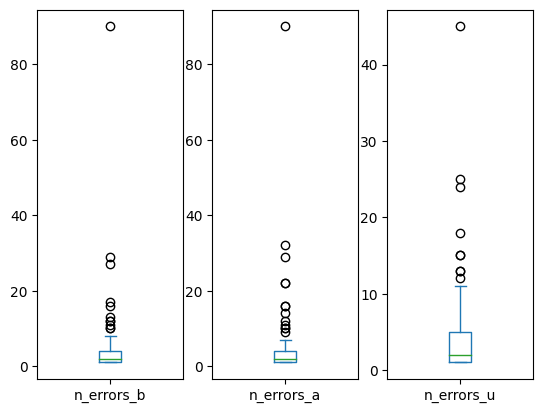

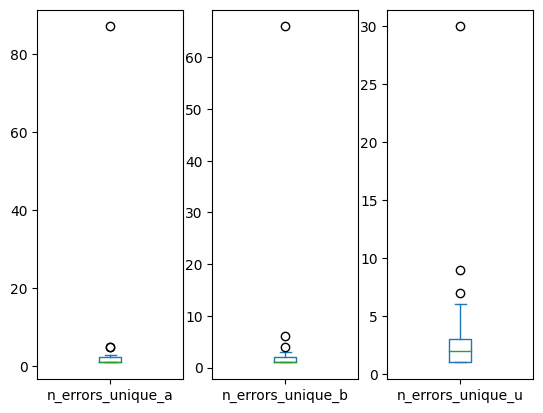

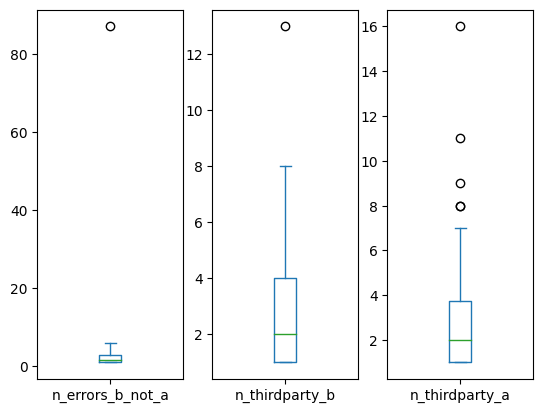

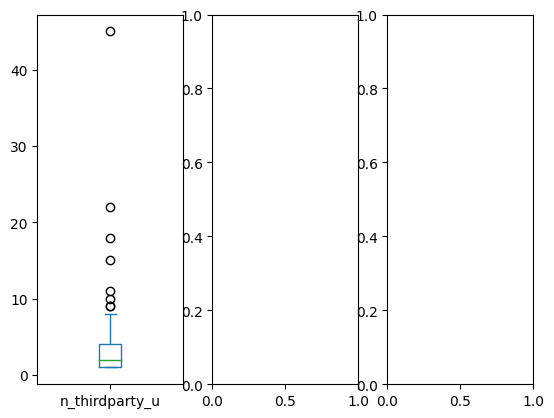

In [10]:
df = pd.read_csv(UBLOCK.OUTPUT_DIR.joinpath("error_stats.csv"))

cols = df.columns[2:]


for i in range(0,len(cols), 3):

    fig, axes = plt.subplots(1,3)

    df[cols[i]][df[cols[i]] > 0].plot.box( ax=axes[0])
    
    if i + 1 < len(cols):
        df[cols[i+1]][df[cols[i+1]] > 0].plot.box(ax=axes[1])
    
    if i + 2< len(cols):
        df[cols[i+2]][df[cols[i+2]] > 0].plot.box(ax=axes[2])

    fig.show()


## investigating script interaction


In [33]:
importlib.reload(sys.modules["BreakageClassifier.code.crawl.interact"])
importlib.reload(sys.modules["BreakageClassifier.code.crawl.dom"])


<module 'BreakageClassifier.code.crawl.dom' from '/home/saiid/summer22-SaiidHajj/BreakageClassifier/code/crawl/dom.py'>

#### crawling

In [6]:
from collections import namedtuple

from BreakageClassifier.code.crawl.dom import DomDumpCommand


browser_params = [BrowserParams(display_mode="headless")]
# browser_params = [BrowserParams()]

# Update browser configuration (use this for per-browser settings)
for browser_param in browser_params:
    # Record HTTP Requests and Responses
    browser_param.http_instrument = True
    # Record cookie changes
    browser_param.cookie_instrument = True
    # Record Navigations
    browser_param.navigation_instrument = True
    # Record JS Web API calls
    browser_param.js_instrument = True
    # Record the callstack of all WebRequests made
    browser_param.callstack_instrument = True
    # Record DNS resolution
    browser_param.dns_instrument = True
    # save the javascript files
    browser_param.save_content = "script"

    browser_param.js_instrument_settings = [
        "collection_fingerprinting",
        {
            "window": {
                "propertiesToInstrument": [
                    "name",
                    "localStorage",
                    "sessionStorage",
                    "onerror"
                ],
                "nonExistingPropertiesToInstrument": [
                    "last_log_event",
                ],
            }
        },
        { "window.console":{
            "logCallStack": True
        }},
        { "window.document":{
            "propertiesToInstrument":{
                "getElementById",
                "getElementsByClassName",
                "getElementsByTagName",
                "querySelector",
                "querySelectorAll",
                },
            "logCallStack": True
        }}
    ]
    

manager_params = ManagerParams(
    num_browsers=1,
    data_directory=Path("./error-handling-out/datadir-error"),
    log_path=Path("./error-handling-out/datadir-error/openwpm.log"),
)

with TaskManager(
    manager_params,
    browser_params,
    SQLiteStorageProvider(Path(f"./error-handling-out/datadir-error/crawl-data.sqlite").resolve()),
    LevelDbProvider(Path(f"./error-handling-out/datadir-error/content.ldb").resolve()),
) as manager:

    create_dom_table(manager_params)
    create_interaction_table(manager_params)
    create_errors_table(manager_params)
    
    row = issue

    # for _, row in dynamic_df.iterrows():
    # load the ublock extension
    command_sequence = CommandSequence(
        row.test_url,
        site_rank=0,
    )

    command_sequence.append_command(
        AddonSetupCommand(path=str(Path(UBLOCK_XPI_PATH).absolute()))
    )

    # command_sequence.append_command(AddonCheckAndUUIDCommand())

    command_sequence.append_command(
        FilterListLoadCommand(path=IN_PATH / "filterlists"/ str(row.id) / "before.txt")
    )

    command_sequence.append_command(GetCommand(url=row.test_url, sleep=20), timeout=200)

    # command_sequence.append_command(AddErrorHandlerCommand())
    
    command_sequence.append_command(DomDumpCommand(), timeout=200)
    
    command_sequence.append_command(SelectorInteractCommand(css_selector=CLICKABLE_CSS_SELECTOR))

    # command_sequence.append_command(
    #     SalientDomDumpCommand(
    #         model_path="../../../WebModelGen/block_classifier/pretrained-models/model-0.joblib",
    #     )
    # )

    # command_sequence.append_command(SalientRandomInteractCommand(), timeout=120)
    # command_sequence.append_command(HarvestErrorsCommand())

    manager.execute_command_sequence(command_sequence)


browser_manager      - INFO     - BROWSER 1659662196: Launching browser...
storage_controller   - INFO     - Awaiting all tasks for visit_id -1
task_manager         - INFO     - 

OpenWPM Version: b'0631dd5'
Firefox Version: b'100.0'

========== Manager Configuration ==========
{
  "_failure_limit": null,
  "data_directory": "/home/saiid/summer22-SaiidHajj/Experiments/error-handling-out/datadir-error",
  "log_path": "/home/saiid/summer22-SaiidHajj/Experiments/error-handling-out/datadir-error/openwpm.log",
  "logger_address": [
    "127.0.0.1",
    52065
  ],
  "memory_watchdog": false,
  "num_browsers": 1,
  "process_watchdog": false,
  "screenshot_path": "/home/saiid/summer22-SaiidHajj/Experiments/error-handling-out/datadir-error/screenshots",
  "source_dump_path": "/home/saiid/summer22-SaiidHajj/Experiments/error-handling-out/datadir-error/sources",
  "storage_controller_address": [
    "127.0.0.1",
    40685
  ],
  "testing": false
}

========== Browser Configuration ==========
Keys

Executing <Task pending name='Task-12' coro=<StorageController._handler() running at /home/saiid/OpenWPM/openwpm/storage/storage_controller.py:95> wait_for=<Future pending cb=[Task.task_wakeup()] created at /home/saiid/miniconda3/envs/openwpm/lib/python3.10/asyncio/base_events.py:429> created at /home/saiid/miniconda3/envs/openwpm/lib/python3.10/asyncio/streams.py:244> took 0.188 seconds


browser_manager      - INFO     - BROWSER 1659662196: EXECUTING COMMAND: DomDumpCommand
browser_manager      - INFO     - BROWSER 1659662196: EXECUTING COMMAND: SelectorInteractCommand


Executing <Task pending name='Task-856' coro=<StorageController._handler() running at /home/saiid/OpenWPM/openwpm/storage/storage_controller.py:95> wait_for=<Future pending cb=[Task.task_wakeup()] created at /home/saiid/miniconda3/envs/openwpm/lib/python3.10/asyncio/base_events.py:429> created at /home/saiid/miniconda3/envs/openwpm/lib/python3.10/asyncio/streams.py:244> took 0.200 seconds


storage_controller   - INFO     - Terminating handler, because the underlying socket closed
browser_manager      - INFO     - BROWSER 1659662196: EXECUTING COMMAND: FinalizeCommand(5)
storage_controller   - INFO     - Terminating handler, because the underlying socket closed
browser_manager      - INFO     - Finished working on CommandSequence with visit_id 2927112625888470 on browser with id 1659662196
storage_controller   - INFO     - Awaiting all tasks for visit_id 2927112625888470
storage_controller   - INFO     - Terminating handler, because the underlying socket closed
storage_controller   - INFO     - Terminating handler, because the underlying socket closed
storage_controller   - INFO     - Received shutdown signal!
Shutdown took 43.04397416114807 seconds


#### features


In [56]:
import importlib
importlib.reload(sys.modules[Database.__module__])
from BreakageClassifier.code.graph.database import Database
importlib.reload(sys.modules["BreakageClassifier.code.graph.utils"])
importlib.reload(sys.modules["BreakageClassifier.code.graph.error"])
importlib.reload(sys.modules["BreakageClassifier.code.graph.requests"])
importlib.reload(sys.modules["BreakageClassifier.code.graph.html_edges"])
importlib.reload(sys.modules["BreakageClassifier.code.run"])


importlib.reload(features)


import BreakageClassifier.code.run as features

In [ ]:
# building the graph

with Database(Path("error-handling-out/datadir-error/crawl-data.sqlite"), UBLOCK.EXP_PATH) as database:
    last_visit = pd.read_sql(
        "SELECT * from site_visits", database.conn
    )
    
    last_visit = last_visit.iloc[len(last_visit)-1]
    
    _, dom, nodes, edges = features.build_graph(database, last_visit.visit_id, last_visit.site_url, None)

##  testing feature pipeline

added a a graph with the following nodes
- script node
- interaction node
- dom node

the following edges exist
- interaction --> script: Error
- interaction --> dom: Query
- script --> dom: Query
- script --> script: Global Error

In [ ]:
crawler = Crawler(
    data_dir="error-handling-out/ublock/datadir",
    saliency_classifier_path=SALIENCY_MODEL_PATH,
    forced=True
)

crawler.crawl_from_dataset(
    metadata = str(UBLOCK.FILTERLISTS_DIR.parent.joinpath("ublock-data.csv").resolve()),
    filterlists_path = UBLOCK.FILTERLISTS_DIR,
    num = 1,
    debug_issue=ISSUE_ID
)

In [ ]:
with Database(Path("error-handling-out/ublock/datadir/crawl-data.sqlite"), UBLOCK.EXP_PATH) as database:

    sites_visits = database.sites_visits()
    
    _edits, issue_log, df_nodes, df_edges = features.process_issue(
        issue = sites_visits.iloc[0], 
        database = database
    )

In [5]:
features.pipeline(
    Path("error-handling-out/ublock/datadir/crawl-data.sqlite"),
    Path("error-handling-out/ublock/datadir/experiments.csv"),
    Path("error-handling-out/ublock/datadir/content.ldb"),
    UBLOCK.FILTERLISTS_DIR,
    Path("earror-handling-out/ublock/features"),
    overwrite=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO ISSUE 13489

INFO ISSUE 13489



  0%|          | 0/1 [00:02<?, ?it/s]

DEBUG Building no-to-fixed diff-tree

DEBUG Building no-to-fixed diff-tree



: 

: 